In [ ]:
# 背景知识
barcodes.tsv：每一行对应 一个细胞（cell）。行数 = 细胞数量
genes.tsv 或 features.tsv ： 每一行对应 一个基因（或特征）。第1列：基因 ID 第2列：基因名称（如 MIR1302-2HG）
matrix.mtx： 表达量矩阵的实际数值（以稀疏矩阵格式）
             基因数（gene行数）   细胞数（barcodes行数）      UMI 计数
             33538               5000                       1234567
             1                     1                          5
             2                     1                          1

R中的Seurat的结构:
        Seurat对象 (类似一个"数据包")
        ├── Assays (表达矩阵层)          # 存储基因表达数据
        │   └── RNA (默认assay)
        │       ├── counts: 原始UMI计数矩阵  [基因×细胞]
        │       ├── data: 标准化后的表达矩阵
        │       └── scale.data: 缩放后的数据
        ├── Meta.data (细胞元数据)       # 类似数据库的表
        │   ├── nCount_RNA: 每个细胞的UMI总数
        │   ├── nFeature_RNA: 每个细胞检测到的基因数
        │   ├── percent.mt: 线粒体基因比例
        │   ├── sample_id: 样本ID
        │   └── group: 实验分组
        ├── Graphs (细胞关系网络)
        ├── Neighbors (最近邻关系)
        ├── Reductions (降维结果)
        │   ├── pca: PCA降维坐标
        │   ├── umap: UMAP可视化坐标
        │   └── tsne: t-SNE可视化坐标
        └── Commands (记录分析步骤)

In [53]:
suppressMessages({
library(Seurat)
library(SeuratDisk) # 用于读取 H5AD 文件
library(ggplot2)
library(patchwork)
library(harmony)
library(tibble)
library(slingshot)
library(clusterProfiler)
library(enrichplot)  # 这个包专门用于富集结果的可视化
library(stringr)
library(dplyr)
library(org.Mm.eg.db)
library(Matrix)})

In [54]:
packageVersion("Seurat")

[1] ‘5.1.0’

In [55]:
# --- 定义路径和文件 ---
directory <- "/media/desk16/iy11913/single_cell/data"
result_dir <- "/media/desk16/iy11913/single_cell/result"
intermediate_dir <- file.path(result_dir, "intermediate_data")

# 确保所有目录存在
dir.create(result_dir, recursive = TRUE, showWarnings = FALSE)
dir.create(intermediate_dir, recursive = TRUE, showWarnings = FALSE)

# 定义样本信息 (基于您的输入)
samples_info <- list(
  "Sample_1_CD" = list(folder = "GSM7664011_Sample_1_CD", group = "CD_Control"),
  "Sample_2_CD" = list(folder = "GSM7664012_Sample_2_CD", group = "CD_Control"), 
  "Sample_3_CD" = list(folder = "GSM7664013_Sample_3_CD", group = "CD_Control"),
  "Sample_1_HFD" = list(folder = "GSM7664014_Sample_1_HFD", group = "HFD_Sample"),
  "Sample_2_HFD" = list(folder = "GSM7664015_Sample_2_HFD", group = "HFD_Sample"),
  "Sample_3_HFD" = list(folder = "GSM7664016_Sample_3_HFD", group = "HFD_Sample")
)

# 辅助函数: 保存图片
save_plot <- function(plot_obj, step_num, title, prefix = "plot", width = 8, height = 6) {
    step_dir <- file.path(result_dir, sprintf("%02d_%s", step_num, gsub(" ", "_", head(str_split(title, "_")[[1]], 1))))
    dir.create(step_dir, recursive = TRUE, showWarnings = FALSE)
    filename <- file.path(step_dir, paste0(prefix, "_", gsub("[^a-zA-Z0-9_]", "", title), ".png"))
    ggsave(filename, plot = plot_obj, width = width, height = height)
    cat(paste("图表已保存到:", filename, "\n"))
}

# 辅助函数: 保存中间结果
save_intermediate <- function(obj, step_num, name) {
    filename <- file.path(intermediate_dir, sprintf("%02d_%s.rds", step_num, name))
    saveRDS(obj, filename)
    cat(paste("中间结果已保存到:", filename, "\n"))
}

In [56]:
cat("--- 1. 数据加载与预处理 (Read10X) --- \n")
seurat_list <- list()

for (sample_name in names(samples_info)) {
    info <- samples_info[[sample_name]]
    folder_path <- file.path(directory, info$folder)
    
    cat(paste("正在加载:", folder_path, "\n"))
    
    # 使用 Read10X 读取 Cell Ranger 格式数据
    tryCatch({
        data <- Read10X(data.dir = folder_path)
        
        # 创建 Seurat 对象
        obj <- CreateSeuratObject(counts = data, project = "scRNAseq", min.cells = 3, min.features = 200)
        
        # 添加元数据
        obj$sample_id <- sample_name
        obj$group <- info$group
        
        # 计算线粒体基因比例 (鼠源，使用 "^mt-" 开头)
        obj[["percent.mt"]] <- PercentageFeatureSet(obj, pattern = "^mt-")
        seurat_list[[sample_name]] <- obj
    }, error = function(e) {
        cat(paste("!!! 错误: 无法读取或创建Seurat对象:", folder_path, ". 错误信息:", e$message, "\n"))
    })
}

# --- 中间结果保存 (Step 1) ---
save_intermediate(seurat_list, 1, "raw_seurat_list")

--- 1. 数据加载与预处理 (Read10X) --- 
正在加载: /media/desk16/iy11913/single_cell/data/GSM7664011_Sample_1_CD 
正在加载: /media/desk16/iy11913/single_cell/data/GSM7664012_Sample_2_CD 
正在加载: /media/desk16/iy11913/single_cell/data/GSM7664013_Sample_3_CD 
正在加载: /media/desk16/iy11913/single_cell/data/GSM7664014_Sample_1_HFD 
正在加载: /media/desk16/iy11913/single_cell/data/GSM7664015_Sample_2_HFD 
正在加载: /media/desk16/iy11913/single_cell/data/GSM7664016_Sample_3_HFD 
中间结果已保存到: /media/desk16/iy11913/single_cell/result/intermediate_data/01_raw_seurat_list.rds 


In [7]:
cat("--- 2. 质量控制 (QC) 与 3. 过滤 --- \n")
filtered_list <- list()

for (sample_id in names(seurat_list)) {
    obj <- seurat_list[[sample_id]]
    
    # 2.1 绘制QC提琴图 
    p_qc <- VlnPlot(obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), 
                    ncol = 3, group.by = "sample_id", pt.size = 0.1) + 
            ggtitle(paste(sample_id, "QC Metrics"))
    save_plot(p_qc, 2, paste0("QC_Violin_Plot_", sample_id), prefix = sample_id, width = 10, height = 4)

    # 3.1 过滤低质量细胞
    # 标准过滤：基因数 > 200 & 基因数 < 2500 & 线粒体比例 < 5%
    obj <- subset(obj, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
    filtered_list[[sample_id]] <- obj
}

# 3.2 合并所有样本
combined_seurat <- merge(filtered_list[[1]], y = filtered_list[-1], 
                         add.cell.ids = names(filtered_list), project = "MergedData")

# --- 中间结果保存 (Step 3) ---
save_intermediate(combined_seurat, 3, "filtered_merged_seurat")

--- 2. 质量控制 (QC) 与 3. 过滤 --- 


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of percent.mt.”


图表已保存到: /media/desk16/iy11913/single_cell/result/02_QC/Sample_1_CD_QC_Violin_Plot_Sample_1_CD.png 


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of percent.mt.”


图表已保存到: /media/desk16/iy11913/single_cell/result/02_QC/Sample_2_CD_QC_Violin_Plot_Sample_2_CD.png 


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of percent.mt.”


图表已保存到: /media/desk16/iy11913/single_cell/result/02_QC/Sample_3_CD_QC_Violin_Plot_Sample_3_CD.png 


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of percent.mt.”


图表已保存到: /media/desk16/iy11913/single_cell/result/02_QC/Sample_1_HFD_QC_Violin_Plot_Sample_1_HFD.png 


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of percent.mt.”


图表已保存到: /media/desk16/iy11913/single_cell/result/02_QC/Sample_2_HFD_QC_Violin_Plot_Sample_2_HFD.png 


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of percent.mt.”


图表已保存到: /media/desk16/iy11913/single_cell/result/02_QC/Sample_3_HFD_QC_Violin_Plot_Sample_3_HFD.png 
中间结果已保存到: /media/desk16/iy11913/single_cell/result/intermediate_data/03_filtered_merged_seurat.rds 


--- 4-6. 归一化/Log转换/HVG识别 --- 


Normalizing layer: counts.1

Normalizing layer: counts.2

Normalizing layer: counts.3

Normalizing layer: counts.4

Normalizing layer: counts.5

Normalizing layer: counts.6

Finding variable features for layer counts.1

Finding variable features for layer counts.2

Finding variable features for layer counts.3

Finding variable features for layer counts.4

Finding variable features for layer counts.5

Finding variable features for layer counts.6

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 3183 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 3183 rows containing missing values or values outside the scale range
(`geom_point()`).”


图表已保存到: /media/desk16/iy11913/single_cell/result/06_HVG/plot_HVG_Dispersion_Plot.png 


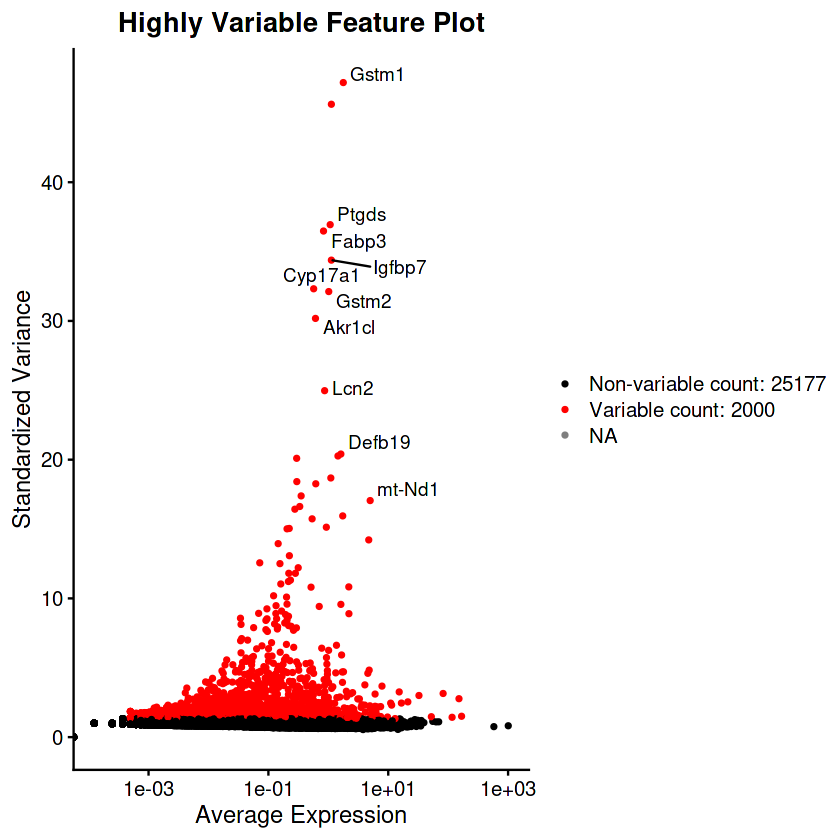

In [8]:
cat("--- 4-6. 归一化/Log转换/HVG识别 --- \n")
# 4. 归一化与 5. Log转换：Seurat默认使用LogNormalize
# normalized_value = log1p( (UMI_count / total_UMI_per_cell) × scale.factor )
# 具体步骤：
# 1. 对每个细胞的每个基因：UMI_count / 该细胞总UMI数（nCount_RNA）
# 2. 乘以 scale.factor（默认10000，即10^4）
# 3. 加1后取自然对数：log1p(x) = ln(1 + x)
combined_seurat <- NormalizeData(combined_seurat, normalization.method = "LogNormalize", scale.factor = 10000)

# 6. 识别高变异基因
# standardized_variance = (observed_variance - expected_variance) / expected_variance
# vst方法的核心思想：
# 1. 对每个基因，建立表达均值-方差关系模型
# 2. 使用局部回归（loess）拟合期望方差
# 3. 计算标准化方差（残差）
# 其中：
# observed_variance = 基因在所有细胞中的表达方差
# expected_variance = 根据该基因的平均表达水平预测的方差

combined_seurat <- FindVariableFeatures(combined_seurat, selection.method = "vst", nfeatures = 2000)

# 6.1 绘制HVG图
top10 <- head(VariableFeatures(combined_seurat), 10)
p_hvf <- VariableFeaturePlot(combined_seurat)
p_hvf <- LabelPoints(plot = p_hvf, points = top10, repel = TRUE) + 
    ggtitle("Highly Variable Feature Plot")
p_hvf
save_plot(p_hvf, 6, "HVG_Dispersion_Plot")

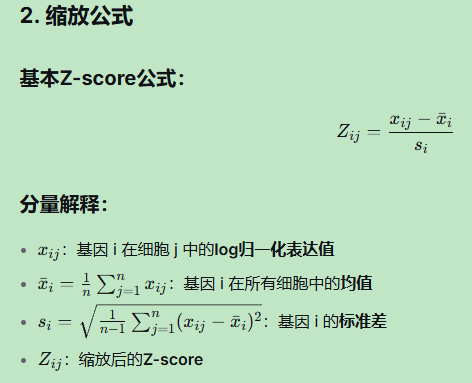

In [14]:
cat("--- 7. 缩放 (Scaling) --- \n")
# 7.1 缩放 (ScaleData): 在原始 RNA Assay 上对 HVG 进行缩放
DefaultAssay(combined_seurat) <- "RNA"
# 确保只对 HVG 进行缩放，同时回归批次和 QC 变量

combined_seurat <- ScaleData(combined_seurat,
                             features = VariableFeatures(object = combined_seurat),
                              # 关键参数2：回归去除技术偏差
                             vars.to.regress = c("nCount_RNA", "percent.mt"))
# -------------------------------------------------------------


--- 7. 缩放 (Scaling) --- 


Regressing out nCount_RNA, percent.mt

Centering and scaling data matrix



--- 8. Harmony 批次效应矫正/整合 (高速) --- 


Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony converged after 4 iterations

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
16:09:15 UMAP embedding parameters a = 0.9922 b = 1.112

16:09:15 Read 42688 rows and found 20 numeric columns

16:09:15 Using Annoy for neighbor search, n_neighbors = 30

16:09:15 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:09:22 Writing NN index file to temp file /tmp/RtmplJFyDS/file3d9d0b4f8e1ac2

16:09:

图表已保存到: /media/desk16/iy11913/single_cell/result/08_Batch/plot_Batch_Correction_Comparison.png 
中间结果已保存到: /media/desk16/iy11913/single_cell/result/intermediate_data/08_harmony_corrected_seurat.rds 
--- 9. 评估维度 (沿用旧的 10 步逻辑) --- 
图表已保存到: /media/desk16/iy11913/single_cell/result/09_PCA/plot_PCA_Elbow_Plot.png 


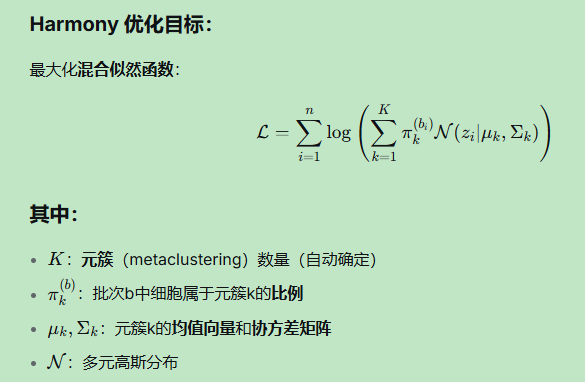

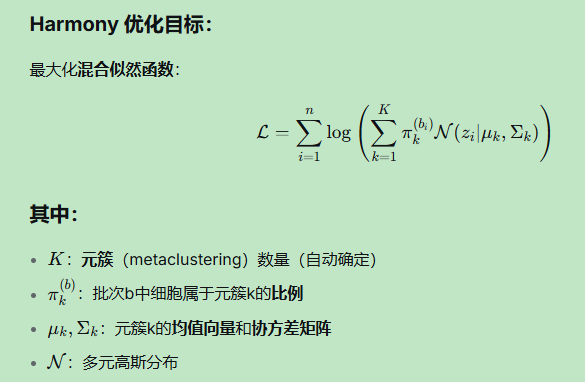

In [ ]:
cat("--- 8. Harmony 批次效应矫正/整合 (高速) --- \n")
# 8.1 PCA 降维 (Harmony 的前提)
combined_seurat <- RunPCA(combined_seurat, 
                         features = VariableFeatures(object = combined_seurat), 
                         npcs = 50, # 增加维度以保留信息，Harmony 将在这个空间中校正
                         verbose = FALSE)
# 8.2 Harmony 批次矫正
combined_seurat <- RunHarmony(combined_seurat, 
                             group.by.vars = "sample_id", 
                             assay.use = "RNA",
                             reduction = "pca", # 使用 PCA 结果作为输入
                             reduction.save = "harmony") # 将结果保存为 'harmony' 嵌入
# 8.3 批次矫正前后 UMAP 快速对比 (可选但推荐)
combined_seurat <- RunUMAP(combined_seurat, dims = 1:20, reduction = "pca", reduction.name = "umap_pca")
combined_seurat <- RunUMAP(combined_seurat, dims = 1:20, reduction = "harmony", reduction.name = "umap_harmony")
p_pca_orig <- DimPlot(combined_seurat, reduction = "umap_pca", group.by = "sample_id", pt.size = 0.5) + 
    ggtitle("Original UMAP (PCA Basis)") + NoLegend()
p_harmony_corr <- DimPlot(combined_seurat, reduction = "umap_harmony", group.by = "sample_id", pt.size = 0.5) + 
    ggtitle("Harmony UMAP (Corrected Basis)")
# 绘制批次矫正效果对比图 
save_plot(p_pca_orig + p_harmony_corr, 8, "Batch_Correction_Comparison", width = 12, height = 6)
# --- 中间结果保存 (Step 8) ---
save_intermediate(combined_seurat, 8, "harmony_corrected_seurat")

In [ ]:
# -------------------------------------------------------------
cat("--- 9. 评估维度 (沿用旧的 10 步逻辑) --- \n")
# 9.1 PCA Elbow Plot (评估降维效果)
# 虽然我们使用 Harmony 矫正，但初始 PCA 的方差贡献图仍有参考价值
p_elbow <- ElbowPlot(combined_seurat, ndims = 50) + 
    ggtitle("PCA Elbow Plot (Before Harmony)")
save_plot(p_elbow, 9, "PCA_Elbow_Plot")

# 假设选择 20 维 (N_PCS 仍然有效)
N_PCS <- 20

In [15]:
# 假设选择 20 维 (N_PCS 仍然有效)
N_PCS <- 10

In [16]:
cat("--- 10. 构建 KNN 图与 11. 聚类 --- \n")
# 10.1 构建 KNN 图 (使用 Harmony 矫正后的嵌入)
combined_seurat <- FindNeighbors(combined_seurat, 
                                 reduction = "harmony", # *** 使用 Harmony ***
                                 dims = 1:N_PCS) 
# 11.1 聚类 (Leiden/Louvain)
combined_seurat <- FindClusters(combined_seurat, resolution = 0.5, random.seed = 42)
combined_seurat$leiden <- combined_seurat$RNA_snn_res.0.5

--- 10. 构建 KNN 图与 11. 聚类 --- 


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 42688
Number of edges: 1395582

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9023
Number of communities: 20
Elapsed time: 15 seconds


In [17]:
cat("--- 12. 非线性降维 (UMAP/tSNE) --- \n")
# UMAP/tSNE 基于 Harmony 矫正后的嵌入
combined_seurat <- RunUMAP(combined_seurat, 
                           reduction = "harmony", # *** 使用 Harmony ***
                           dims = 1:N_PCS)

# 12.1 UMAP聚类结果图
p_umap_cluster <- DimPlot(combined_seurat, reduction = "umap", group.by = "leiden", label = TRUE, repel = TRUE) + 
    ggtitle("UMAP Colored by Leiden Clustering (Harmony)")
save_plot(p_umap_cluster, 12, "UMAP_Leiden_Clusters_Harmony")

# 12.2 UMAP按组别分布 (检查矫正效果)
p_umap_group <- DimPlot(combined_seurat, reduction = "umap", group.by = "group") + 
    ggtitle("UMAP Colored by Group (Harmony)")
save_plot(p_umap_group, 12, "UMAP_Group_Distribution_Harmony")

# --- 中间结果保存 (Step 12) ---
save_intermediate(combined_seurat, 12, "umap_clustered_harmony_seurat")

--- 12. 非线性降维 (UMAP/tSNE) --- 


16:20:55 UMAP embedding parameters a = 0.9922 b = 1.112

16:20:55 Read 42688 rows and found 10 numeric columns

16:20:55 Using Annoy for neighbor search, n_neighbors = 30

16:20:55 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:21:02 Writing NN index file to temp file /tmp/RtmplJFyDS/file3d9d0b1974ca99

16:21:02 Searching Annoy index using 1 thread, search_k = 3000

16:21:23 Annoy recall = 100%

16:21:23 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:21:26 Initializing from normalized Laplacian + noise (using RSpectra)

16:21:30 Commencing optimization for 200 epochs, with 1821632 positive edges

16:21:58 Optimization finished



图表已保存到: /media/desk16/iy11913/single_cell/result/12_UMAP/plot_UMAP_Leiden_Clusters_Harmony.png 
图表已保存到: /media/desk16/iy11913/single_cell/result/12_UMAP/plot_UMAP_Group_Distribution_Harmony.png 
中间结果已保存到: /media/desk16/iy11913/single_cell/result/intermediate_data/12_umap_clustered_harmony_seurat.rds 


In [26]:
cat("--- 13. 寻找聚类差异表达基因 (Seurat v5 修正) --- \n")

# 14.1 确保使用原始 RNA Assay
DefaultAssay(combined_seurat) <- "RNA" 

# *** 关键修正步骤：使用 JoinLayers 合并 Assay 数据层 ***
# Seurat v5 默认是分层存储，FindAllMarkers 需要合并层才能正确访问所有数据。
# 将 RNA Assay 的所有数据层合并
combined_seurat[["RNA"]] <- JoinLayers(combined_seurat[["RNA"]])
cat("RNA Assay 数据层已合并。\n")

# 14.2 设置用于分组的 ID (之前聚类结果保存在 'leiden' 列)
Idents(combined_seurat) <- "leiden" 

# 14.3 查找所有聚类的标记基因
combined_seurat.markers <- FindAllMarkers(
    object = combined_seurat, 
    only.pos = TRUE, 
    min.pct = 0.25, 
    logfc.threshold = 0.25
)

# 14.4 中间结果保存
markers_path <- file.path(intermediate_dir, "13_Cluster_Markers.csv")
write.csv(combined_seurat.markers, markers_path, row.names = FALSE)
cat(paste("聚类标记基因已保存到:", markers_path, "\n"))

--- 14. 寻找聚类差异表达基因 (Seurat v5 修正) --- 
RNA Assay 数据层已合并。


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19



聚类标记基因已保存到: /media/desk16/iy11913/single_cell/result/intermediate_data/14_Cluster_Markers.csv 


In [27]:
cat("--- 14. 标记基因可视化 --- \n")

# --- 标记基因可视化 (原 14) ---
# 检查 FindAllMarkers 结果是否非空
if (nrow(combined_seurat.markers) == 0) {
    cat("⚠️ 警告: combined_seurat.markers 为空，无法进行可视化。请尝试降低 FindAllMarkers 阈值 (如 logfc.threshold = 0.1)。\n")
    # 尝试用通用免疫细胞标记基因替代，以便至少展示绘图功能
    top5 <- data.frame(cluster = 1, gene = c("CD3D", "CD79A", "CD14", "PECAM1", "COL1A1"))
    top5 <- top5[top5$gene %in% rownames(combined_seurat), ]
    if (nrow(top5) == 0) stop("无法找到标记基因且通用标记基因也缺失，无法进行可视化。")
} else {
    # 提取每个聚类的 Top 5 基因
    top5 <- combined_seurat.markers %>% 
        group_by(cluster) %>% 
        slice_max(n = 5, order_by = avg_log2FC)
}

# 15.1 DotPlot (点图) 
p_dotplot <- DotPlot(combined_seurat, features = unique(top5$gene), cols = c("blue", "red"), dot.scale = 8, group.by = "leiden") + 
    RotatedAxis() + ggtitle("Top Marker Genes DotPlot")
save_plot(p_dotplot, 14, "DotPlot_Top_Markers", width = 12, height = 6)

# 15.2 FeaturePlot (UMAP着色图)
representative_markers <- unique(top5$gene[1:min(4, length(top5$gene))])
# FeaturePlot 需要 'data' 层，在 Seurat v5 中 JoinLayers 已经处理
p_feature <- FeaturePlot(combined_seurat, features = representative_markers, ncol = 2, reduction = "umap") + 
    plot_layout(guides = "collect")
save_plot(p_feature, 14, "FeaturePlot_Representative_Markers", width = 10, height = 8)

# 15.3 热图 (Heatmap)
p_heatmap <- DoHeatmap(combined_seurat, features = top5$gene, group.by = "leiden", assay = "RNA") + 
    NoLegend() + ggtitle("Top Marker Genes Heatmap")
save_plot(p_heatmap, 14, "Heatmap_Top_Markers", width = 10, height = 15)



--- 14-15. 标记基因可视化与细胞类型注释 --- 
图表已保存到: /media/desk16/iy11913/single_cell/result/15_DotPlot/plot_DotPlot_Top_Markers.png 
图表已保存到: /media/desk16/iy11913/single_cell/result/15_FeaturePlot/plot_FeaturePlot_Representative_Markers.png 


Warning message in DoHeatmap(combined_seurat, features = top5$gene, group.by = "leiden", :
“The following features were omitted as they were not found in the scale.data slot for the RNA assay: Gpr37, Gm4181, 1700023F02Rik, 1700104B16Rik, Gm15262, Tchp, Ppp1r27, Glipr1l2, Gm4763, Gm3149, Gm3476, Ssxb1, Ssxb2, Wdr38, Fam71f2, Spem1, Gapdhs, Gm13324, 1700074H08Rik, 4930567H17Rik, Frat1, Gm14725, Prm1, 1700008P02Rik, Klk1, H2al1m, Cypt14, Olfr303, 4930571K23Rik, Reep6, Spem2”


图表已保存到: /media/desk16/iy11913/single_cell/result/15_Heatmap/plot_Heatmap_Top_Markers.png 
图表已保存到: /media/desk16/iy11913/single_cell/result/15_UMAP/plot_UMAP_Annotated_Cell_Types_Final.png 
中间结果已保存到: /media/desk16/iy11913/single_cell/result/intermediate_data/15_annotated_seurat.rds 


In [ ]:
cat("--- 15. 细胞类型注释 --- \n")
# 警告: 请根据步骤 15.1 的可视化结果手动确定 cell_type 名称。
new_cluster_ids <- paste0("CellType_", 1:length(levels(combined_seurat$leiden))) 
names(new_cluster_ids) <- levels(combined_seurat$leiden)

combined_seurat <- RenameIdents(combined_seurat, new_cluster_ids)
combined_seurat$cell_type <- Idents(combined_seurat)

# 15.4 绘制注释后的 UMAP 
p_annotated_umap <- DimPlot(combined_seurat, reduction = "umap", label = TRUE, repel = TRUE, group.by = "cell_type") + 
    ggtitle("UMAP Colored by Annotated Cell Types")
save_plot(p_annotated_umap, 15, "UMAP_Annotated_Cell_Types_Final")

# --- 中间结果保存 (Step 15) ---
save_intermediate(combined_seurat, 15, "annotated_seurat")

In [28]:
cat("--- 16. 组间差异表达分析 (DE) --- \n")
# 目标：寻找 HFD_Sample vs CD_Control 的差异基因，在某个细胞类型中进行 (例如：CellType_1)
target_cell_type <- levels(combined_seurat$cell_type)[1] # 假设第一个细胞类型
target_seurat <- subset(combined_seurat, subset = cell_type == target_cell_type & group %in% c("HFD_Sample", "CD_Control"))

# 重新设置分组信息，确保对照组在前
target_seurat$condition <- factor(target_seurat$group, levels = c("CD_Control", "HFD_Sample"))
Idents(target_seurat) <- "condition"

# 使用原始 RNA 数据进行差异分析
de_results <- FindMarkers(target_seurat, ident.1 = "HFD_Sample", ident.2 = "CD_Control", 
                          assay = "RNA", logfc.threshold = 0.25, min.pct = 0.1)

# --- 中间结果保存 (Step 16) ---
de_path <- file.path(intermediate_dir, paste0("16_DE_Genes_", gsub(" ", "_", target_cell_type), ".csv"))
write.csv(de_results, de_path, row.names = TRUE)
cat(paste("差异表达基因已保存到:", de_path, "\n"))

--- 16. 组间差异表达分析 (DE) --- 
差异表达基因已保存到: /media/desk16/iy11913/single_cell/result/intermediate_data/16_DE_Genes_CellType_1.csv 


In [32]:
cat("--- 17. DE 可视化 (火山图 & 热图) --- \n")
# ... (代码与前面提供的相同，不需要修改)
de_results_plot <- de_results %>% 
    rownames_to_column(var = "gene") %>% 
    mutate(
        threshold = case_when(
            avg_log2FC >= 0.5 & p_val_adj < 0.05 ~ "Up",
            avg_log2FC <= -0.5 & p_val_adj < 0.05 ~ "Down",
            TRUE ~ "None"
        ),
        p_val_neglog = -log10(p_val_adj)
    )

# 17.1 绘制火山图 
p_volcano <- ggplot(de_results_plot, aes(x = avg_log2FC, y = p_val_neglog, color = threshold)) +
    geom_point(alpha = 0.4, size = 1.5) +
    scale_color_manual(values = c("Up" = "red", "Down" = "blue", "None" = "grey")) +
    geom_vline(xintercept = c(-0.5, 0.5), linetype = "dashed", color = "black") +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "black") +
    labs(title = paste0("Volcano Plot in ", target_cell_type, " (HFD vs CD)")) + theme_minimal()

save_plot(p_volcano, 17, paste0("Volcano_Plot_", target_cell_type))

# 17.2 绘制热图 (Top 50 DEGs)
top_deg_genes <- de_results_plot %>% 
    filter(threshold != "None") %>% 
    arrange(desc(abs(avg_log2FC))) %>% 
    head(50) %>% 
    pull(gene)

p_heatmap_de <- DoHeatmap(target_seurat, features = top_deg_genes, group.by = "condition", assay = "RNA") +
    ggtitle(paste0("Top 50 DEGs Heatmap in ", target_cell_type))
save_plot(p_heatmap_de, 17, "Heatmap_DE_Genes", width = 10, height = 15)

--- 17. DE 可视化 (火山图 & 热图) --- 
图表已保存到: /media/desk16/iy11913/single_cell/result/17_Volcano/plot_Volcano_Plot_CellType_1.png 


Warning message in DoHeatmap(target_seurat, features = top_deg_genes, group.by = "condition", :
“The following features were omitted as they were not found in the scale.data slot for the RNA assay: Rps24-ps3, Eif1b, 1700052I22Rik, 1700016K19Rik, Rpl21, Med9os, Poln, Tex30, 4930507D10Rik, 1700001G01Rik, 4933438B17Rik, AC154806.1, 1700021F07Rik, Gm2415, 4930579O11Rik, Gm3848, Tmem132cos, Gm34358, Gm13976, Pemt, 1700097N02Rik, Klk1b26, 4933424L21Rik, 4930527E20Rik, Gm35453, Fnbp1l, Gm8730, Gucy2d, Nme5, Sord, Rpl26, Aars2, Fhit, Nmnat3, Pga5, 1700021J08Rik, Sftpb, Klf1, Gm16231, Cd55, 4933409F18Rik, Fmn1, Rab44, Gm34732, Gm11942”


图表已保存到: /media/desk16/iy11913/single_cell/result/17_Heatmap/plot_Heatmap_DE_Genes.png 


In [33]:
cat("--- 18. 细胞丰度变化分析 --- \n")
# ... (代码与前面提供的相同，不需要修改)
cell_counts <- combined_seurat@meta.data %>%
    filter(group %in% c("HFD_Sample", "CD_Control")) %>%
    group_by(group, cell_type) %>%
    summarise(n = n(), .groups = 'drop_last') %>%
    mutate(proportion = n / sum(n)) %>%
    ungroup()

# 18.2 绘制柱状图展示丰度变化
p_prop <- ggplot(cell_counts, aes(x = group, y = proportion, fill = cell_type)) +
    geom_bar(stat = "identity", position = "stack") +
    labs(y = "Cell Proportion", title = "Cell Type Proportion by Group") +
    theme_minimal() +
    scale_fill_discrete(name = "Cell Type")
save_plot(p_prop, 18, "Cell_Type_Proportion")

--- 18. 细胞丰度变化分析 --- 
图表已保存到: /media/desk16/iy11913/single_cell/result/18_Cell/plot_Cell_Type_Proportion.png 


In [38]:
cat("--- 19. 细胞轨迹分析与 20. 伪时间计算 --- \n")
# ... (代码与前面提供的相同，不需要修改)
sce <- as.SingleCellExperiment(combined_seurat)
sce$label <- as.factor(combined_seurat$leiden)

# 使用 Harmony 矫正后的 UMAP 坐标
rd <- Embeddings(combined_seurat, reduction = "umap")

# 19.1 运行 Slingshot
start_cluster <- combined_seurat$leiden %>% as.character() %>% unique() %>% head(1)
sce_slingshot <- slingshot(sce, reducedDim = rd, clusterLabels = 'leiden', start.clus = start_cluster)

# 20.1 提取伪时间
pseudotime <- slingPseudotime(sce_slingshot)
combined_seurat$pseudotime <- pseudotime[,1] 

# 20.2 UMAP 伪时间图 
p_pt_umap <- FeaturePlot(combined_seurat, features = "pseudotime", reduction = "umap", label = TRUE) + 
    ggtitle("UMAP Colored by Pseudotime (Trajectory 1)") + 
    scale_color_viridis_c() 
save_plot(p_pt_umap, 20, "UMAP_Pseudotime_Trajectory")

# --- 中间结果保存 (Step 20) ---
save_intermediate(combined_seurat, 20, "pseudotime_seurat")

--- 19. 细胞轨迹分析与 20. 伪时间计算 --- 


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


图表已保存到: /media/desk16/iy11913/single_cell/result/20_UMAP/plot_UMAP_Pseudotime_Trajectory.png 
中间结果已保存到: /media/desk16/iy11913/single_cell/result/intermediate_data/20_pseudotime_seurat.rds 


In [46]:
cat("--- 21. 基因富集分析 (GSEA/GO/KEGG) (鼠源实现) --- \n")

# 确保加载富集分析所需包
# 假设 clusterProfiler 和 org.Mm.eg.db 已经加载 (由用户保证)
library(clusterProfiler)
# library(org.Mm.eg.db) # 鼠源数据库
cat("富集分析包已加载 (使用 org.Mm.eg.db)。\n")

# --- A. 基因集富集分析 (GSEA/GO) ---

# 21.1 准备 GSEA 输入数据 (Ranked gene list)
# 依赖于步骤 17 生成的 de_results_plot
if (!exists("de_results_plot") || nrow(de_results_plot) == 0) {
    cat("⚠️ 警告: de_results_plot 对象不存在或为空。跳过 GSEA。\n")
    gsea_results <- NULL 
} else {
    cat("正在准备基因列表并运行 GSEA... \n")
    
    # 排序基因列表：按 avg_log2FC 降序排列 (这是 GSEA 的标准输入格式)
    gene_list <- de_results_plot$avg_log2FC
    names(gene_list) <- de_results_plot$gene
    gene_list <- sort(gene_list, decreasing = TRUE)
    
    if(length(gene_list) > 100 && sum(abs(gene_list) > 0) > 0) {
        
        # 运行 GO-GSEA 分析 (使用 gseGO)
        gsea_results <- gseGO(
            geneList = gene_list, 
            OrgDb = org.Mm.eg.db, # *** 鼠源数据库 ***
            keyType = "SYMBOL", 
            ont = "BP", # Biological Process (可改为 CC/MF 或 ALL)
            minGSSize = 10,
            maxGSSize = 500,
            pvalueCutoff = 0.05,
            verbose = FALSE,
            seed = TRUE # 确保结果可重复
        )
        
        # 过滤和简化结果 (去除冗余的 GO Term)
        gsea_results_sim <- simplify(gsea_results, cutoff = 0.7, by = "p.adjust", select_fun = min)
        
        # 21.2 GSEA 结果可视化 (Dotplot) 
        if (nrow(gsea_results_sim) > 0) {
            # 绘制 GO 富集 Dotplot
            p_dotplot_gsea <- dotplot(gsea_results_sim, showCategory = 10, title = paste0("Top 10 GO GSEA Results in ", target_cell_type)) + 
                theme_minimal()
            save_plot(p_dotplot_gsea, 21, "GO_GSEA_DotPlot_Mouse", width = 10, height = 8)
            cat("GO GSEA Dot Plot 已保存。\n")
        } else {
            cat("警告: 没有找到显著的 GO GSEA 结果。\n")
        }
    
    } else {
        cat("警告: 差异基因数量过少或列表为空，跳过 GSEA。\n")
        gsea_results <- NULL
    }
}


# --- B. 基因打分 (AddModuleScore, 保持不变) ---
cat("\n正在运行 AddModuleScore 示例...\n")
# 假设是鼠源增殖通路基因，使用标准命名
proliferation_genes <- c("Mki67", "Pcna", "Cdk1", "Top2a") 
proliferation_genes_in_data <- proliferation_genes[proliferation_genes %in% rownames(combined_seurat)]

if(length(proliferation_genes_in_data) > 0) {
    # 确保 assay 为 RNA
    DefaultAssay(combined_seurat) <- "RNA"
    
    combined_seurat <- AddModuleScore(
        object = combined_seurat,
        features = list(Prolif = proliferation_genes_in_data),
        ctrl = 100, 
        name = 'Proliferation_Score'
    )
    
    # 21.3 UMAP 通路分数图 
    p_score_umap <- FeaturePlot(combined_seurat, features = "Proliferation_Score1", reduction = "umap") + 
        ggtitle("UMAP Colored by Proliferation Score")
    save_plot(p_score_umap, 21, "UMAP_Proliferation_Score")
    cat("增殖模块分数 UMAP 图已保存。\n")
} else {
    cat("警告: 增殖基因不在数据中，跳过打分示例。\n")
}

# --- 最终结果保存 (如果 GSEA 成功，这里可以保存 GSEA 结果) ---
if (exists("gsea_results") && !is.null(gsea_results) && nrow(gsea_results@result) > 0) {
    gsea_path <- file.path(intermediate_dir, paste0("21_GO_GSEA_Results_", gsub(" ", "_", target_cell_type), ".csv"))
    write.csv(gsea_results@result, gsea_path, row.names = FALSE)
    cat(paste("GSEA 结果已保存到:", gsea_path, "\n"))
}

--- 21. 基因富集分析 (GSEA/GO/KEGG) (鼠源实现) --- 
富集分析包已加载 (使用 org.Mm.eg.db)。
正在准备基因列表并运行 GSEA... 


no term enriched under specific pvalueCutoff...



警告: 没有找到显著的 GO GSEA 结果。

正在运行 AddModuleScore 示例...
图表已保存到: /media/desk16/iy11913/single_cell/result/21_UMAP/plot_UMAP_Proliferation_Score.png 
增殖模块分数 UMAP 图已保存。


In [48]:
cat("--- 22. 细胞-细胞相互作用 (CCI) - CellChat 修正版 --- \n")

# 确保加载 CellChat
library(CellChat)
# 确保加载 igraph (通常 CellChat 会自动加载)

# 使用鼠源数据库 (Mouse)
CellChatDB <- CellChatDB.mouse

# 设置 CellChat 使用的数据库
cellchat@DB <- CellChatDB

# 22.1 从 Seurat 对象中获取数据和元数据
# 获取归一化后的数据 (层级 'data') 作为输入
data.input <- GetAssayData(combined_seurat, assay = "RNA", layer = "data") 
meta <- combined_seurat@meta.data
# 使用之前注释的细胞类型 'cell_type' 进行分组
cell.use <- rownames(meta)[meta$cell_type %in% levels(combined_seurat$cell_type)]
data.input <- data.input[, cell.use]
meta <- meta[cell.use, ]

# 创建 CellChat 对象
cellchat <- createCellChat(object = data.input, meta = meta, group.by = "cell_type")
cellchat@DB <- CellChatDB
# 22.2 **【关键修正】** 子集化数据 (Subset Data)
# 这一步是修复您错误的关键。它会根据数据库过滤基因，并将结果写入 cellchat@data.signaling
cellchat <- subsetData(cellchat) 
cat("数据子集化 (subsetData) 已完成。\n")

# 22.3 识别高表达基因 (Identify Over-Expressed Genes)
# 这一步现在应该能够正常运行
cellchat <- identifyOverExpressedGenes(cellchat)
cat("高表达基因识别已完成。\n")

# 22.4 识别高表达配体-受体对 (Identify Over-Expressed Interactions)
cellchat <- identifyOverExpressedInteractions(cellchat)
cat("高表达配体-受体对识别已完成。\n")

--- 22. 细胞-细胞相互作用 (CCI) - CellChat 修正版 --- 


triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2025-12-15 17:32:14.204192]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2025-12-15 17:47:43.651097]"


ERROR: Error in UseMethod("grid.draw"): "grid.draw"没有适用于"recordedplot"目标对象的方法


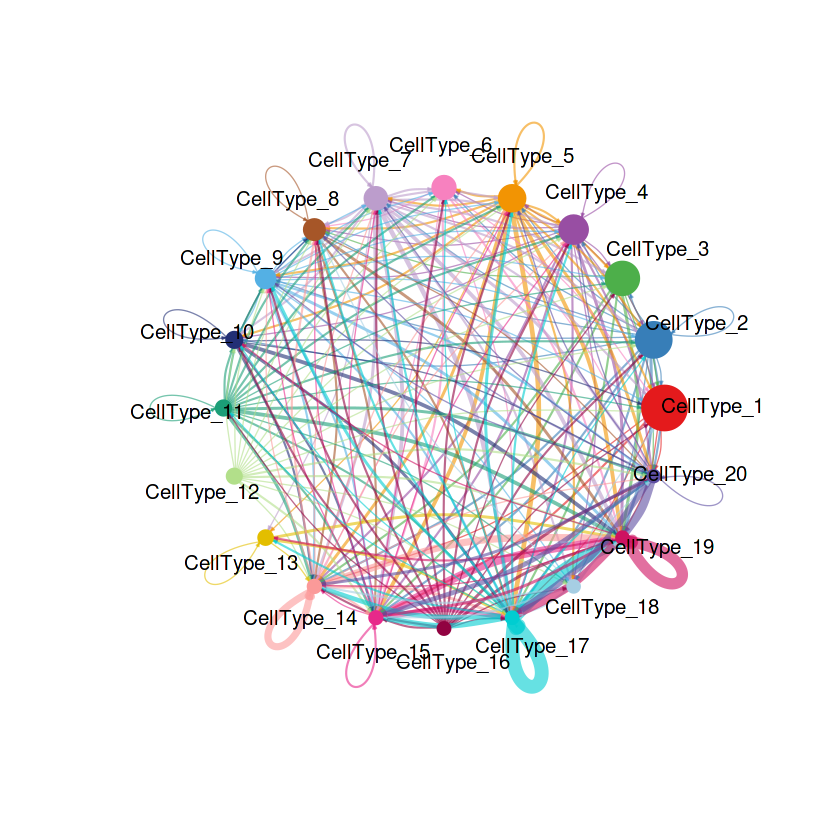

In [51]:
# 22.5 投影基因表达数据到蛋白水平 (可选但推荐)
cellchat <- projectData(cellchat, PPI.mouse)

# 22.6 计算细胞间通讯概率
cellchat <- computeCommunProb(cellchat)

# 22.7 过滤不重要的通讯
cellchat <- filterCommunication(cellchat, min.cells = 10)

# 22.8 推断细胞间通讯网络 
cellchat <- aggregateNet(cellchat)

# 22.9 网络可视化 (Circle Plot 示例)
net_circle <- netVisual_circle(cellchat@net$count, vertex.weight = as.numeric(table(cellchat@idents)), 
                              weight.scale = T, label.edge = F, title.name = "Number of interactions")
save_plot(net_circle, 22, "CellChat_Network_CirclePlot", width = 10, height = 10)

# 22.10 最终结果保存
save_intermediate(cellchat, 22, "final_cellchat_object")
cat("\n🎉 Cell-Cell Interaction (CellChat) 流程已完成并保存结果。\n")

--- 22.9 网络可视化 (Circle Plot 示例) (修正) --- 


ERROR: Error: 找不到对象'plot_dir'


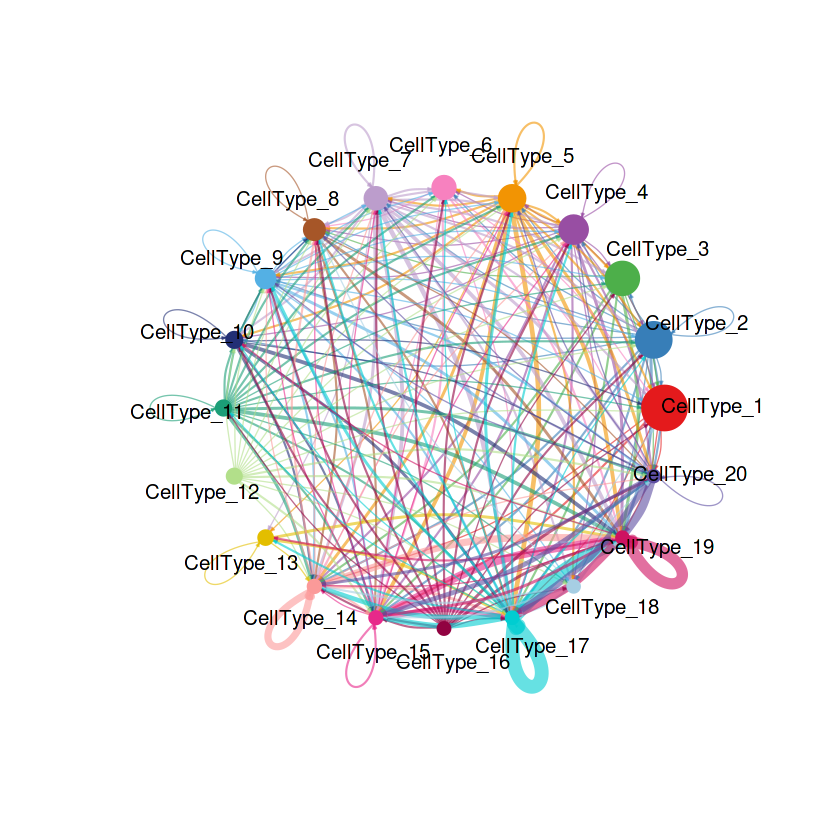

In [52]:
cat("--- 22.9 网络可视化 (Circle Plot 示例) (修正) --- \n")

# 1. 生成 Circle Plot
# netVisual_circle 返回的是基础 R 绘图对象 (或记录对象)
net_circle <- netVisual_circle(cellchat@net$count, 
                               vertex.weight = as.numeric(table(cellchat@idents)), 
                               weight.scale = T, 
                               label.edge = F, 
                               title.name = "Number of interactions")

# 2. 使用基础 R 函数保存图形 (修正后的保存方法)
# 定义输出路径和文件名
file_name <- "CellChat_Network_CirclePlot.pdf"
save_path <- file.path(plot_dir, paste0("22_", file_name))
width <- 10
height <- 10

# 打开 PDF 设备
pdf(save_path, width = width, height = height)
# 绘制图形 (这一步会将 net_circle 对象绘制到打开的 PDF 设备中)
print(net_circle) 
# 关闭设备，完成保存
dev.off() 

cat(paste("网络 Circle Plot 已使用 PDF 格式保存到:", save_path, "\n"))
# 

# 22.10 最终结果保存 (保持不变)
save_intermediate(cellchat, 22, "final_cellchat_object")
cat("\n🎉 Cell-Cell Interaction (CellChat) 流程已完成并保存结果。\n")